In [1]:
library(tidyverse)
library(ggrepel)
library(grid)
library(ggplotify)
library(ragg)
library(ggrastr)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# input is marker_df, generated from FindMarkers
# number of marker genes to display (e.g., 100)
# title = title of the plot
DESeq2_display_volcano_plot <- function(markers_df, number_of_marker_genes, title, 
                                        logfc_threshold = 0.5, pval_threshold = 0.05) {

    # remove NA values
    markers_df <- na.omit(markers_df)
    
    # add a tiny amount to the p-values since log10(0) will not show up
    markers_df$padj <- markers_df$padj + 1e-300

    # Define thresholds for significance
    neg_log_10_p_val_threshold <- -1 * log10(pval_threshold)

    # identify the significant genes
    markers_df$status <- "non-significant"
    markers_df[which(markers_df$log2FoldChange > logfc_threshold & markers_df$padj < pval_threshold), "status"] <- "up"
    markers_df[which(markers_df$log2FoldChange < -1 * logfc_threshold & markers_df$padj < pval_threshold), "status"] <- "down"

    # number of up and downregulated
    num_up_genes <- dim(dplyr::filter(markers_df, status == "up"))[1]
    num_down_genes <- dim(dplyr::filter(markers_df, status == "down"))[1]
    
    # display the top genes that are significant
    significant_genes_df = dplyr::filter(markers_df, status %in% c("up", "down"))
    top_genes <- head(significant_genes_df[order(significant_genes_df$padj), ], number_of_marker_genes)

    # display volcano plot
    volcano_plot <- ggplot(markers_df, aes(x = log2FoldChange, y = -log10(padj))) +
    geom_point(aes(color = status), alpha = 0.8) +
    geom_text_repel(data = top_genes, aes(label = gene_name), size = 3) +
    geom_hline(yintercept = neg_log_10_p_val_threshold, linetype = "dashed", color = "red") +
    scale_color_manual(values = c("non-significant" = "gray", 
                                "up" = "blue",
                                "down" = "red")) +
    labs(title = title, x = "log2(FC)", y = "-log10(adjusted p-value)") +
    annotate("text", x = max(markers_df$log2FoldChange), y = max(-log10(markers_df$padj)) * 1.1,
           label = paste("Upregulated:", num_up_genes), hjust = 1, size = 6) +
    annotate("text", x = min(markers_df$log2FoldChange), y = max(-log10(markers_df$padj)) * 1.1, 
           label = paste("Downregulated:", num_down_genes), hjust = 0, size = 6) +
    ylim(0, max(-log10(markers_df$padj)) * 1.1) + 
    theme_minimal() + 
    theme(plot.title = element_text(size = 24, hjust = 0.5), 
         axis.text.x = element_text(angle = 0, hjust = 1, size = 16),
         axis.text.y = element_text(size = 16), 
         axis.title.x = element_text(size = 18),
         axis.title.y = element_text(size = 18),
         legend.text = element_text(size = 16), 
          legend.title = element_text(size = 18),
         legend.position = "none")

    return(volcano_plot)
}

In [8]:
save_rasterized_volcano_plot <- function(markers_df, number_of_marker_genes, title, output_pdf,
                                         logfc_threshold = 0.5, pval_threshold = 0.05, plot_width = 8, plot_height = 8) {
  library(ggplot2)
  library(ggrepel)
  library(dplyr)

  # Debugging Step 1: Check if markers_df has required columns
  required_columns <- c("log2FoldChange", "padj", "gene_name")
  if (!all(required_columns %in% colnames(markers_df))) {
    stop("Input markers_df must contain the columns: log2FoldChange, padj, and gene_name.")
  }

  # Remove NA values
  markers_df <- na.omit(markers_df)

  # Add a tiny amount to p-values to avoid log10(0)
  markers_df$padj <- markers_df$padj + 1e-300

  # Define thresholds for significance
  neg_log_10_p_val_threshold <- -1 * log10(pval_threshold)

  # Identify significant genes
  markers_df$status <- "non-significant"
  markers_df[which(markers_df$log2FoldChange > logfc_threshold & markers_df$padj < pval_threshold), "status"] <- "up"
  markers_df[which(markers_df$log2FoldChange < -1 * logfc_threshold & markers_df$padj < pval_threshold), "status"] <- "down"

  # Number of up- and downregulated genes
  num_up_genes <- sum(markers_df$status == "up")
  num_down_genes <- sum(markers_df$status == "down")

  # Filter for significant genes and select top genes
  significant_genes_df <- dplyr::filter(markers_df, status %in% c("up", "down"))
  top_genes <- head(significant_genes_df[order(significant_genes_df$padj), ], number_of_marker_genes)

  # Create the volcano plot
  volcano_plot <- ggplot(markers_df, aes(x = log2FoldChange, y = -log10(padj))) +
    geom_point_rast(aes(color = status), alpha = 0.8) +
    geom_text_repel(data = top_genes, aes(label = gene_name), size = 3) +
    geom_hline(yintercept = neg_log_10_p_val_threshold, linetype = "dashed", color = "red") +
    scale_color_manual(values = c("non-significant" = "gray", 
                                  "up" = "blue",
                                  "down" = "red")) +
    labs(title = title, x = expression(log[2]~"(fold change)"), y = expression(-log[10]~"(adjusted p-value)")) +
    annotate("text", x = max(markers_df$log2FoldChange), y = max(-log10(markers_df$padj)) * 1.1,
             label = paste("Upregulated:", num_up_genes), hjust = 1, size = 6) +
    annotate("text", x = min(markers_df$log2FoldChange), y = max(-log10(markers_df$padj)) * 1.1, 
             label = paste("Downregulated:", num_down_genes), hjust = 0, size = 6) +
    ylim(0, max(-log10(markers_df$padj)) * 1.1) +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 24, hjust = 0.5), 
      axis.text.x = element_text(angle = 0, hjust = 1, size = 16),
      axis.text.y = element_text(size = 16), 
      axis.title.x = element_text(size = 18),
      axis.title.y = element_text(size = 18),
      legend.text = element_text(size = 16), 
      legend.title = element_text(size = 18),
        legend.position = "none"
    )

  # save as a rasterized PDF using ggsave and cairo_pdf
  ggsave(output_pdf, plot = volcano_plot, device = cairo_pdf, width = plot_width, height = plot_height, dpi = 300)
    
  return(volcano_plot)
}

In [9]:
contrasts <- c("aging - old vs young", "development - fetal vs young", "sex - male vs female", "disease - Y vs N")
num_contrasts <- length(contrasts)

corresponding_contrast_file_names <- c("age-group_old_vs_young", "age-group_fetal_vs_young",
                              "sex_male_vs_female", "disease-binary_Y_vs_N")

cell_types <- c("Cardiomyocyte", "Endothelial", "Fibroblast", "Lymphoid", "Myeloid", "Pericyte")

q_val_threshold <- 0.05
log2_FC_threshold <- 0.5

In [10]:
volcano_plot_ggplots_dir <- "volcano_plots_ggplot2/"
dir.create(volcano_plot_ggplots_dir)

Warning message in dir.create(volcano_plot_ggplots_dir):
“'volcano_plots_ggplot2' already exists”


### Produce PNG plots

In [11]:
options(repr.plot.width = 8, repr.plot.height = 8)

for (cell_type in cell_types) {

    for (i in 1:num_contrasts) {
        contrast_file_name <- corresponding_contrast_file_names[i]

        contrast = contrasts[i]
        
        contrast_file_path <- paste0("pydeseq2_results/", cell_type, "_", contrast_file_name, "_results.csv")
        title = paste0(cell_type, ": ", contrast)

        if (file.exists(contrast_file_path)) {
            DE_res <- read.csv(contrast_file_path)
            DE_res$gene_name <- DE_res$X

            # produce the volcano plot
            p1 <- DESeq2_display_volcano_plot(markers_df = DE_res, 
                            number_of_marker_genes = 100, 
                            title = title, 
                            logfc_threshold = log2_FC_threshold, pval_threshold = q_val_threshold)
            #print(p1)
            output_png <- paste0(volcano_plot_ggplots_dir, cell_type, "-", contrast_file_name, ".png")
            ggsave(p1, filename = output_png, height = 8, width = 8)
            
        }
         else {
            print(paste0("File does not exist:", contrast_file_path))
        }
    }
}

Warning message:
“ggrepel: 84 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 87 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 90 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 91 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 84 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 65 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 86 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 94 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 78 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 74 unlabel

### Save as rasterized pdfs

In [12]:
options(repr.plot.width = 8, repr.plot.height = 8)

for (cell_type in cell_types) {

    for (i in 1:num_contrasts) {
        contrast_file_name <- corresponding_contrast_file_names[i]

        contrast = contrasts[i]
        
        contrast_file_path <- paste0("pydeseq2_results/", cell_type, "_", contrast_file_name, "_results.csv")
        title = paste0(cell_type, ": ", contrast)

        if (file.exists(contrast_file_path)) {
            DE_res <- read.csv(contrast_file_path)
            DE_res$gene_name <- DE_res$X

            # produce the volcano plot
            output_pdf <- paste0(volcano_plot_ggplots_dir, cell_type, "-", contrast_file_name, ".pdf")
            
            p1 <- save_rasterized_volcano_plot(markers_df = DE_res, 
                            number_of_marker_genes = 100, output_pdf = output_pdf,
                            title = title, 
                            logfc_threshold = log2_FC_threshold, pval_threshold = q_val_threshold)
            
        }
         else {
            print(paste0("File does not exist:", contrast_file_path))
        }
    }
}

Warning message:
“ggrepel: 82 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 85 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 88 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 83 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 81 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 56 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 84 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 94 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 76 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 66 unlabel

### Save volcano plots with larger text for main figure

Make the volcano plots for cardiomyocytes.

Warning message:
“ggrepel: 85 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 83 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 87 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 86 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 90 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 85 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


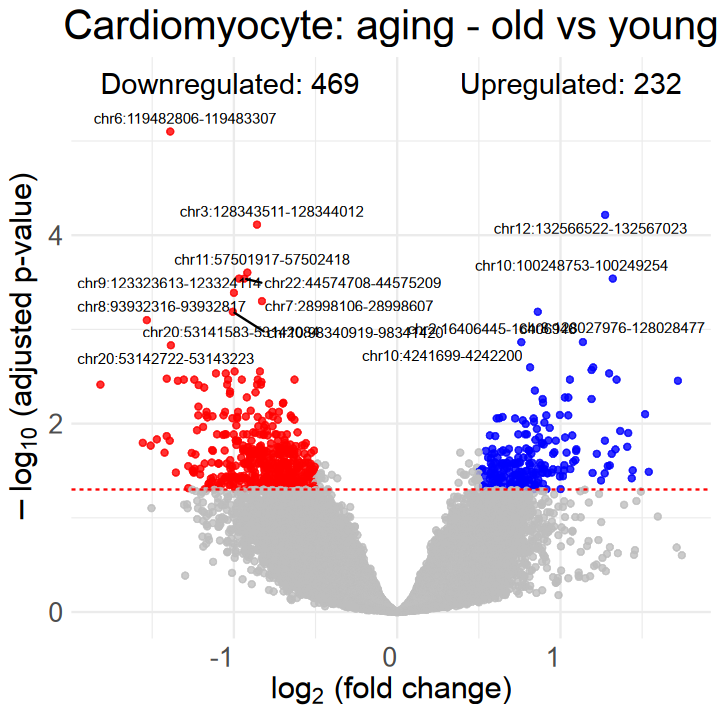

Warning message:
“ggrepel: 90 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 88 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 87 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


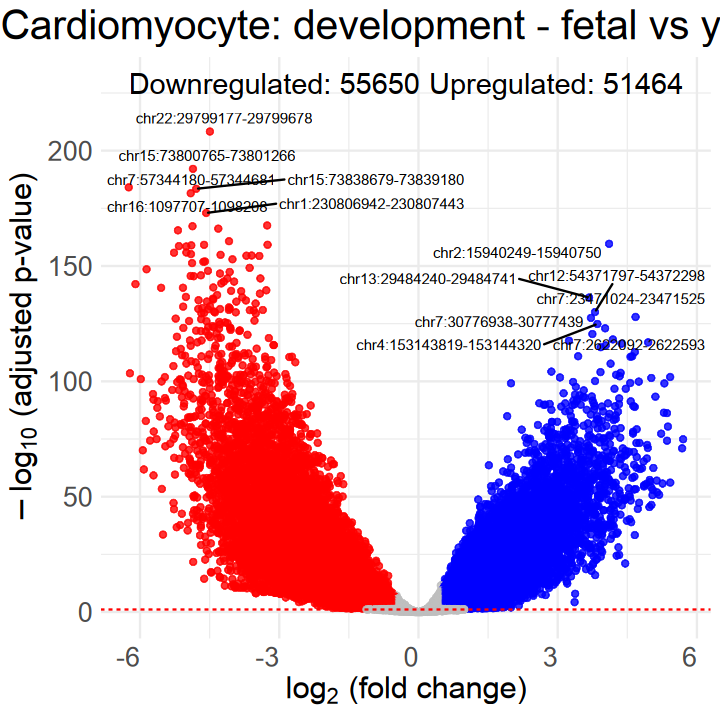

Warning message:
“ggrepel: 84 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 90 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


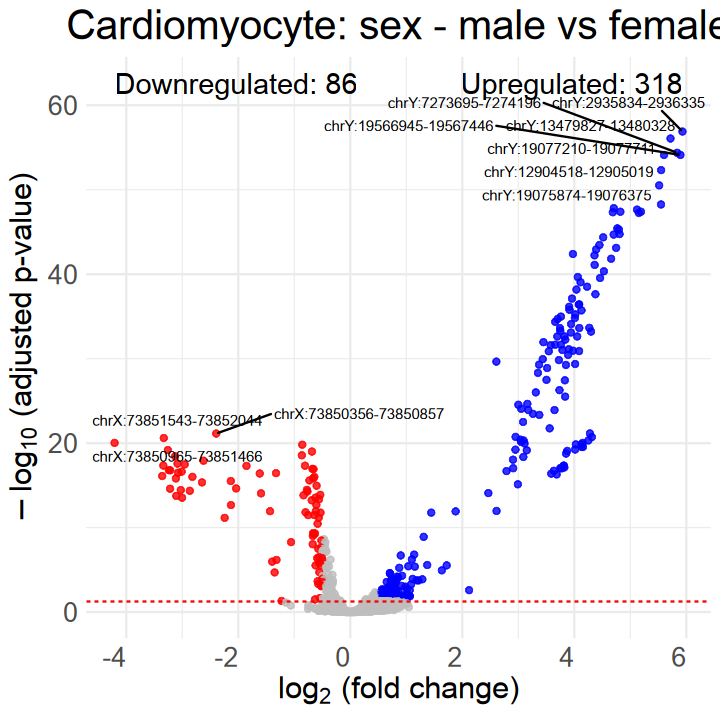

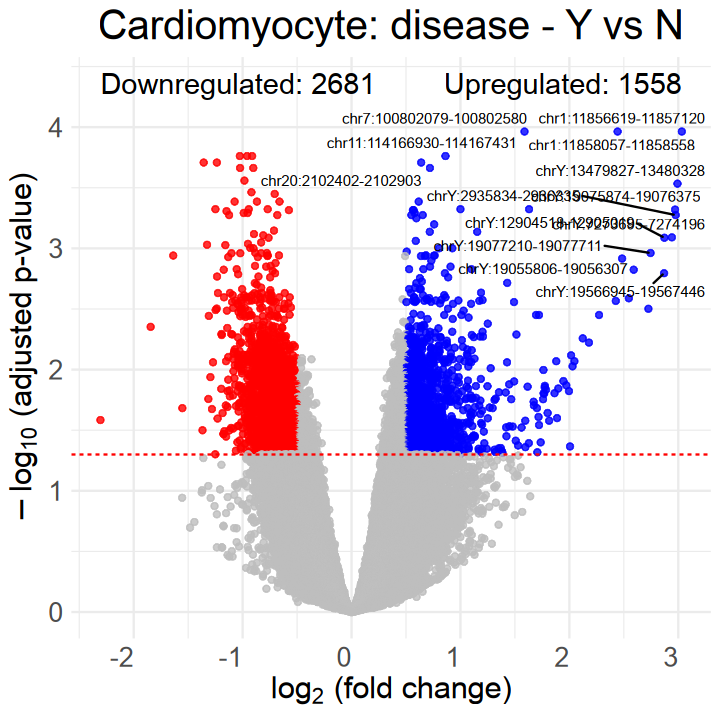

In [13]:
options(repr.plot.width = 6, repr.plot.height = 6)

cell_type <- "Cardiomyocyte" 

for (i in 1:num_contrasts) {
    contrast_file_name <- corresponding_contrast_file_names[i]

    contrast = contrasts[i]
    
    contrast_file_path <- paste0("pydeseq2_results/", cell_type, "_", contrast_file_name, "_results.csv")
    title = paste0(cell_type, ": ", contrast)

    if (file.exists(contrast_file_path)) {
        DE_res <- read.csv(contrast_file_path)
        DE_res$gene_name <- DE_res$X

        # produce the volcano plot
        output_pdf <- paste0(volcano_plot_ggplots_dir, "main_figure_", cell_type, "-", contrast_file_name, ".pdf")
        
        p1 <- save_rasterized_volcano_plot(markers_df = DE_res, 
                        number_of_marker_genes = 100, output_pdf = output_pdf,
                        title = title, 
                        logfc_threshold = log2_FC_threshold, 
                        pval_threshold = q_val_threshold,
                        plot_width = 6,
                        plot_height = 6)
        print(p1)
        
    }
     else {
        print(paste0("File does not exist:", contrast_file_path))
    }
}